The goal of this project is to investigate whether there is a correlation between house prices and the number of crimes in the Leeds area. To accomplish this research, the project will use crime data and median house price data from March 2021 in Leeds as the foundation.

In [88]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns  # some very basic tools for analyzing and visualizing data
from sklearn.cluster import KMeans # KMeans clustering, which we'll use to cluster the crime data and house price data 
crime = pd.read_csv(r"../PythonP/crime.csv")
house = pd.read_csv(r"../PythonP/housepricemid.csv") # read the data,and check the first 5 rows. start from the crime data.
crime.head()

Crime ID    Month  \
0  d9e3417dad8742d480aea5d30b11ae788ed6b7aa267a29...  2021-04   
1  bc4e6efed170af421d98c39e2854e91bf3b933cfdcb4b2...  2021-04   
2  5fd3d231aad8778fa624377045059a8dc4aa3779c3b9c7...  2021-04   
3  7f2d605e3e74585a07e14aa0b04d9a78221e128fe9f98d...  2021-04   
4  c525f6487edef046c82c0adb00492c9a8bc8de3ec29d71...  2021-04   

             Reported by           Falls within  Longitude   Latitude  \
0  West Yorkshire Police  West Yorkshire Police  -1.905890  53.930295   
1  West Yorkshire Police  West Yorkshire Police  -1.877784  53.948129   
2  West Yorkshire Police  West Yorkshire Police  -1.877784  53.948129   
3  West Yorkshire Police  West Yorkshire Police  -1.879359  53.946225   
4  West Yorkshire Police  West Yorkshire Police  -1.887983  53.945918   

                     Location  LSOA code      LSOA name  \
0  On or near Brown Bank Lane  E01010646  Bradford 001A   
1      On or near The Paddock  E01010646  Bradford 001A   
2      On or near The Paddock  E01010646  Bradford 001A   
3        On or near The Acres  E01010646  Bradford 001A   
4       On or near Burns Hill  E01010647  Bradford 001B   

                     Crime type  \
0                      Burglary   
1  Violence and sexual offences   
2  Violence and sexual offences   
3  Violence and sexual offences   
4                         Drugs   

                           Last outcome category  Context  
0  Investigation complete; no suspect identified      NaN  
1                    Unable to prosecute suspect      NaN  
2                    Unable to prosecute suspect      NaN  
3                    Unable to prosecute suspect      NaN  
4                               Local resolution      NaN

In [89]:
crime.info() # check the data type of each column, and see if there are any missing values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26564 entries, 0 to 26563
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Crime ID               22564 non-null  object 
 1   Month                  26564 non-null  object 
 2   Reported by            26564 non-null  object 
 3   Falls within           26564 non-null  object 
 4   Longitude              26035 non-null  float64
 5   Latitude               26035 non-null  float64
 6   Location               26564 non-null  object 
 7   LSOA code              26035 non-null  object 
 8   LSOA name              26035 non-null  object 
 9   Crime type             26564 non-null  object 
 10  Last outcome category  22564 non-null  object 
 11  Context                0 non-null      float64
dtypes: float64(3), object(9)
memory usage: 2.4+ MB


In [90]:
crime.isnull().sum() # check the missing values in each column to see if there any spical pattern.

Crime ID                  4000
Month                        0
Reported by                  0
Falls within                 0
Longitude                  529
Latitude                   529
Location                     0
LSOA code                  529
LSOA name                  529
Crime type                   0
Last outcome category     4000
Context                  26564
dtype: int64

In [91]:
# drop the columns that are not useful for our analysis. At this time, we are not interested in the crime ID, month, reported by...
crimeCln = crime.drop(columns = ["Crime ID","Month","Reported by","Falls within","Longitude","Latitude","Location","Last outcome category","Context"])
crimeCln.isnull().sum()

LSOA code     529
LSOA name     529
Crime type      0
dtype: int64

In [92]:
# LSOA code is the code for Lower Layer Super Output Area, which is a small area in England and Wales. We now will check the missing values in the LSOA code column.
crimeCln.loc[crimeCln["LSOA code"].isna()]

LSOA code LSOA name             Crime type
26035       NaN       NaN  Anti-social behaviour
26036       NaN       NaN  Anti-social behaviour
26037       NaN       NaN  Anti-social behaviour
26038       NaN       NaN  Anti-social behaviour
26039       NaN       NaN  Anti-social behaviour
...         ...       ...                    ...
26559       NaN       NaN            Other crime
26560       NaN       NaN            Other crime
26561       NaN       NaN            Other crime
26562       NaN       NaN            Other crime
26563       NaN       NaN            Other crime

[529 rows x 3 columns]

In [93]:
# We find that there is some crime that have no LSOA code. We will drop these rows.
crimeCln = crimeCln.dropna()
crimeCln.isna().sum()

LSOA code     0
LSOA name     0
Crime type    0
dtype: int64

In [94]:
# that's for the crime data.very basic,but a clean start. Now we will check the house price data.
house.head()

lsoacode  hpmd202003  hpmd202103
0  E01011949     95747.0     92692.0
1  E01011950     55862.0     47887.0
2  E01011951     57350.0     49176.0
3  E01011952     88317.0         NaN
4  E01011953    101061.0    137600.0

In [95]:
# Our crime data is from march 2021, so we will only keep the house price data from march 2021.
houseCln = house.drop(columns = ["hpmd202003"])
houseCln.isna().sum()

lsoacode         0
hpmd202103    1278
dtype: int64

In [96]:
# Unlike crime data,we don't just drop the missing values in the house price data. We will fill the missing values with 0.
houseCln = houseCln.fillna(0)
houseCln.isna().sum()

lsoacode      0
hpmd202103    0
dtype: int64

In [97]:
# Just a quick check of the data type of each column.
houseCln.head

<bound method NDFrame.head of         lsoacode  hpmd202103
0      E01011949     92692.0
1      E01011950     47887.0
2      E01011951     49176.0
3      E01011952         0.0
4      E01011953    137600.0
...          ...         ...
34748  W01001320    183575.0
34749  W01001321    130441.0
34750  W01001322    122119.0
34751  W01001324    160467.0
34752  W01001898         0.0

[34753 rows x 2 columns]>

That's the end of basic data cleaning.next we'll going to process the data in order to be able to analize them.There will be many "transitional" dataframe,just let the step of data processing to be clear,so don't be disturbed by some wired name of those transitional dataframe.

In [98]:
# The first step is count the number of crimes in each LSOA area. We will group the data by LSOA code and crime type, and count the number of crimes in each group.
crimeP = crimeCln.groupby(["LSOA code","Crime type"]).size().reset_index(name = "Count") # crimeP is the "crime in Process"
crimeP.head()

LSOA code                 Crime type  Count
0  E01005410      Anti-social behaviour      2
1  E01005410               Public order      1
2  E01010568      Anti-social behaviour      2
3  E01010568                   Burglary      1
4  E01010568  Criminal damage and arson      2

In [99]:
# Next step is to pivot the table so that each row is a LSOA area, and each column is a crime type. We will fill the missing values with 0.
# This will let us be able to count the number of each type of crime in each LSOA area.
crimeP = crimeP.pivot_table(index = "LSOA code",columns = "Crime type",values = "Count",fill_value = 0)
crimeP.head()

Crime type  Anti-social behaviour  Bicycle theft  Burglary  \
LSOA code                                                    
E01005410                     2.0            0.0       0.0   
E01010568                     2.0            0.0       1.0   
E01010569                     9.0            0.0       0.0   
E01010570                     3.0            0.0       1.0   
E01010571                     2.0            0.0       1.0   

Crime type  Criminal damage and arson  Drugs  Other crime  Other theft  \
LSOA code                                                                
E01005410                         0.0    0.0          0.0          0.0   
E01010568                         2.0    0.0          0.0          0.0   
E01010569                         2.0    0.0          1.0          1.0   
E01010570                         0.0    0.0          0.0          0.0   
E01010571                         3.0    0.0          0.0          3.0   

Crime type  Possession of weapons  Public order  Robbery  Shoplifting  \
LSOA code                                                               
E01005410                     0.0           1.0      0.0          0.0   
E01010568                     0.0           1.0      0.0          0.0   
E01010569                     0.0           3.0      0.0          0.0   
E01010570                     0.0           1.0      0.0          0.0   
E01010571                     0.0           3.0      0.0          1.0   

Crime type  Theft from the person  Vehicle crime  Violence and sexual offences  
LSOA code                                                                       
E01005410                     0.0            0.0                           0.0  
E01010568                     0.0            1.0                           1.0  
E01010569                     0.0            2.0                          20.0  
E01010570                     0.0            0.0                           3.0  
E01010571                     0.0            2.0                           6.0

In [100]:
# Now we can have a look of crime type in the dataframe.
crimeP.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1394 entries, E01005410 to E01035053
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Anti-social behaviour         1394 non-null   float64
 1   Bicycle theft                 1394 non-null   float64
 2   Burglary                      1394 non-null   float64
 3   Criminal damage and arson     1394 non-null   float64
 4   Drugs                         1394 non-null   float64
 5   Other crime                   1394 non-null   float64
 6   Other theft                   1394 non-null   float64
 7   Possession of weapons         1394 non-null   float64
 8   Public order                  1394 non-null   float64
 9   Robbery                       1394 non-null   float64
 10  Shoplifting                   1394 non-null   float64
 11  Theft from the person         1394 non-null   float64
 12  Vehicle crime                 1394 non-null   float64


In [101]:
# Reset the index in order to make the LSOA code a column, so that we can merge the crime data with the house price data.
crimeP2 = crimeP.reset_index()
crimeP2.head()

Crime type  LSOA code  Anti-social behaviour  Bicycle theft  Burglary  \
0           E01005410                    2.0            0.0       0.0   
1           E01010568                    2.0            0.0       1.0   
2           E01010569                    9.0            0.0       0.0   
3           E01010570                    3.0            0.0       1.0   
4           E01010571                    2.0            0.0       1.0   

Crime type  Criminal damage and arson  Drugs  Other crime  Other theft  \
0                                 0.0    0.0          0.0          0.0   
1                                 2.0    0.0          0.0          0.0   
2                                 2.0    0.0          1.0          1.0   
3                                 0.0    0.0          0.0          0.0   
4                                 3.0    0.0          0.0          3.0   

Crime type  Possession of weapons  Public order  Robbery  Shoplifting  \
0                             0.0           1.0      0.0          0.0   
1                             0.0           1.0      0.0          0.0   
2                             0.0           3.0      0.0          0.0   
3                             0.0           1.0      0.0          0.0   
4                             0.0           3.0      0.0          1.0   

Crime type  Theft from the person  Vehicle crime  Violence and sexual offences  
0                             0.0            0.0                           0.0  
1                             0.0            1.0                           1.0  
2                             0.0            2.0                          20.0  
3                             0.0            0.0                           3.0  
4                             0.0            2.0                           6.0

In [102]:
# Merge the crime data with the house price data. We will merge the data on the LSOA code column.
CrimeData1 = pd.merge(crimeP2,houseCln,left_on = "LSOA code",right_on = "lsoacode",how = "left") #Still, CrimeData1 is a transitional dataframe.
CrimeData1.head

<bound method NDFrame.head of       LSOA code  Anti-social behaviour  Bicycle theft  Burglary  \
0     E01005410                    2.0            0.0       0.0   
1     E01010568                    2.0            0.0       1.0   
2     E01010569                    9.0            0.0       0.0   
3     E01010570                    3.0            0.0       1.0   
4     E01010571                    2.0            0.0       1.0   
...         ...                    ...            ...       ...   
1389  E01033697                    1.0            0.0       1.0   
1390  E01033900                    0.0            0.0       0.0   
1391  E01034582                    0.0            0.0       0.0   
1392  E01035050                    0.0            0.0       0.0   
1393  E01035053                    0.0            0.0       0.0   

      Criminal damage and arson  Drugs  Other crime  Other theft  \
0                           0.0    0.0          0.0          0.0   
1                           2

In [103]:
# Drop the redundant lsoacode column. we already have the LSOA code.
CrimeData1.drop(columns = ["lsoacode"],inplace = True)
CrimeData1.head()

LSOA code  Anti-social behaviour  Bicycle theft  Burglary  \
0  E01005410                    2.0            0.0       0.0   
1  E01010568                    2.0            0.0       1.0   
2  E01010569                    9.0            0.0       0.0   
3  E01010570                    3.0            0.0       1.0   
4  E01010571                    2.0            0.0       1.0   

   Criminal damage and arson  Drugs  Other crime  Other theft  \
0                        0.0    0.0          0.0          0.0   
1                        2.0    0.0          0.0          0.0   
2                        2.0    0.0          1.0          1.0   
3                        0.0    0.0          0.0          0.0   
4                        3.0    0.0          0.0          3.0   

   Possession of weapons  Public order  Robbery  Shoplifting  \
0                    0.0           1.0      0.0          0.0   
1                    0.0           1.0      0.0          0.0   
2                    0.0           3.0      0.0          0.0   
3                    0.0           1.0      0.0          0.0   
4                    0.0           3.0      0.0          1.0   

   Theft from the person  Vehicle crime  Violence and sexual offences  \
0                    0.0            0.0                           0.0   
1                    0.0            1.0                           1.0   
2                    0.0            2.0                          20.0   
3                    0.0            0.0                           3.0   
4                    0.0            2.0                           6.0   

   hpmd202103  
0    349624.0  
1    224611.0  
2    168978.0  
3    422778.0  
4    143759.0

In [104]:
# Check if there are any missing values in the merged data.
CrimeData1.isna().sum()

LSOA code                       0
Anti-social behaviour           0
Bicycle theft                   0
Burglary                        0
Criminal damage and arson       0
Drugs                           0
Other crime                     0
Other theft                     0
Possession of weapons           0
Public order                    0
Robbery                         0
Shoplifting                     0
Theft from the person           0
Vehicle crime                   0
Violence and sexual offences    0
hpmd202103                      4
dtype: int64

In [105]:
# Strangelly there are some missing values. we will check the rows with missing values to see if anything is wrong.
CrimeData1.loc[CrimeData1["hpmd202103"].isna()]

LSOA code  Anti-social behaviour  Bicycle theft  Burglary  \
1390  E01033900                    0.0            0.0       0.0   
1391  E01034582                    0.0            0.0       0.0   
1392  E01035050                    0.0            0.0       0.0   
1393  E01035053                    0.0            0.0       0.0   

      Criminal damage and arson  Drugs  Other crime  Other theft  \
1390                        0.0    1.0          0.0          0.0   
1391                        0.0    0.0          0.0          0.0   
1392                        0.0    0.0          0.0          0.0   
1393                        0.0    0.0          0.0          0.0   

      Possession of weapons  Public order  Robbery  Shoplifting  \
1390                    0.0           0.0      0.0          0.0   
1391                    0.0           0.0      0.0          0.0   
1392                    0.0           1.0      0.0          0.0   
1393                    0.0           0.0      0.0          0.0   

      Theft from the person  Vehicle crime  Violence and sexual offences  \
1390                    0.0            0.0                           0.0   
1391                    0.0            0.0                           1.0   
1392                    0.0            0.0                           1.0   
1393                    0.0            0.0                           1.0   

      hpmd202103  
1390         NaN  
1391         NaN  
1392         NaN  
1393         NaN

In [106]:
# Nothing special, we will fill the missing values with 0.
CrimeData2 = CrimeData1.fillna(0)
CrimeData2.isna().sum()

LSOA code                       0
Anti-social behaviour           0
Bicycle theft                   0
Burglary                        0
Criminal damage and arson       0
Drugs                           0
Other crime                     0
Other theft                     0
Possession of weapons           0
Public order                    0
Robbery                         0
Shoplifting                     0
Theft from the person           0
Vehicle crime                   0
Violence and sexual offences    0
hpmd202103                      0
dtype: int64

In [107]:
# But we find that the house price data is in string format. We will convert it to integer.
CrimeType = CrimeData2.columns.drop(["LSOA code","hpmd202103"]) # This step is to pull out the crime type columns. We may need them later.
CrimeData2[CrimeType] = CrimeData2[CrimeType].astype(int)
CrimeData2["hpmd202103"] = CrimeData2["hpmd202103"].astype(int)
CrimeData2.head()

LSOA code  Anti-social behaviour  Bicycle theft  Burglary  \
0  E01005410                      2              0         0   
1  E01010568                      2              0         1   
2  E01010569                      9              0         0   
3  E01010570                      3              0         1   
4  E01010571                      2              0         1   

   Criminal damage and arson  Drugs  Other crime  Other theft  \
0                          0      0            0            0   
1                          2      0            0            0   
2                          2      0            1            1   
3                          0      0            0            0   
4                          3      0            0            3   

   Possession of weapons  Public order  Robbery  Shoplifting  \
0                      0             1        0            0   
1                      0             1        0            0   
2                      0             3        0            0   
3                      0             1        0            0   
4                      0             3        0            1   

   Theft from the person  Vehicle crime  Violence and sexual offences  \
0                      0              0                             0   
1                      0              1                             1   
2                      0              2                            20   
3                      0              0                             3   
4                      0              2                             6   

   hpmd202103  
0      349624  
1      224611  
2      168978  
3      422778  
4      143759

In [108]:
# Beautifully done. Now we will calculate the total number of all types of crimes in each LSOA area.
CrimeData2["Total Crime"] = CrimeData2[CrimeType].sum(axis = 1)
CrimeData2.head()

LSOA code  Anti-social behaviour  Bicycle theft  Burglary  \
0  E01005410                      2              0         0   
1  E01010568                      2              0         1   
2  E01010569                      9              0         0   
3  E01010570                      3              0         1   
4  E01010571                      2              0         1   

   Criminal damage and arson  Drugs  Other crime  Other theft  \
0                          0      0            0            0   
1                          2      0            0            0   
2                          2      0            1            1   
3                          0      0            0            0   
4                          3      0            0            3   

   Possession of weapons  Public order  Robbery  Shoplifting  \
0                      0             1        0            0   
1                      0             1        0            0   
2                      0             3        0            0   
3                      0             1        0            0   
4                      0             3        0            1   

   Theft from the person  Vehicle crime  Violence and sexual offences  \
0                      0              0                             0   
1                      0              1                             1   
2                      0              2                            20   
3                      0              0                             3   
4                      0              2                             6   

   hpmd202103  Total Crime  
0      349624            3  
1      224611            8  
2      168978           38  
3      422778            8  
4      143759           21

In [109]:
# Now we have another task: can we join the LSOA name within our dataframe? the answer is yes. But we need to start from the very beginning.
crimeLoc = crime[["LSOA code","LSOA name"]].drop_duplicates() # There some duplicate rows in dataframe,becaues that is how the data originally persent different crime types. we'll drop the duplicates.
crimeLoc.head()

LSOA code      LSOA name
0   E01010646  Bradford 001A
4   E01010647  Bradford 001B
6   E01010692  Bradford 001D
16  E01010691  Bradford 002A
23  E01010693  Bradford 002B

In [110]:
# Now is time to merge our final dataframe.
CrimeData = pd.merge(CrimeData2,crimeLoc,on = "LSOA code",how = "left")
CrimeData.head()

LSOA code  Anti-social behaviour  Bicycle theft  Burglary  \
0  E01005410                      2              0         0   
1  E01010568                      2              0         1   
2  E01010569                      9              0         0   
3  E01010570                      3              0         1   
4  E01010571                      2              0         1   

   Criminal damage and arson  Drugs  Other crime  Other theft  \
0                          0      0            0            0   
1                          2      0            0            0   
2                          2      0            1            1   
3                          0      0            0            0   
4                          3      0            0            3   

   Possession of weapons  Public order  Robbery  Shoplifting  \
0                      0             1        0            0   
1                      0             1        0            0   
2                      0             3        0            0   
3                      0             1        0            0   
4                      0             3        0            1   

   Theft from the person  Vehicle crime  Violence and sexual offences  \
0                      0              0                             0   
1                      0              1                             1   
2                      0              2                            20   
3                      0              0                             3   
4                      0              2                             6   

   hpmd202103  Total Crime      LSOA name  
0      349624            3    Oldham 006A  
1      224611            8  Bradford 016A  
2      168978           38  Bradford 016B  
3      422778            8  Bradford 018A  
4      143759           21  Bradford 016C

In [111]:
# A bautifully done dataframe. We will save it as a csv file.
CrimeData.to_csv(r"../PythonP/CrimeData.csv", index = False)

Next, we will begin preparing for detailed analysis and visualization. The first step is to start by reading the LSOA (Lower Layer Super Output Area) boundary shapefile for the study area.

In [112]:
SHP = gpd.read_file(r"../PythonP/LeedsLSOA/LeedsLSOA.shp") # The .shp file is pre-processed by myself in ArcGIS pro. It contains the boundary of each LSOA area in Leeds.

In [113]:
# Whill processing the .shp file,we found the LSOA code in .shp file is called "lsoa21cd", which is different from the LSOA code in our crime data. We will rename the column to "LSOA code".
SHP = SHP.rename(columns = {"lsoa21cd":"LSOA code"})

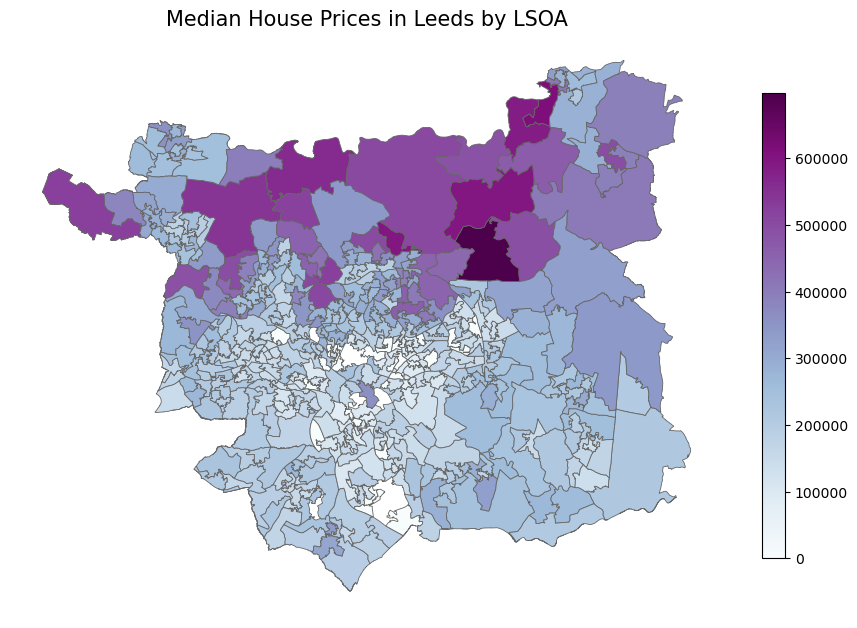

In [118]:
# Now we will merge the shapefile with our crime data,and plot the median house price in each LSOA area.
Merged = SHP.merge(CrimeData,on = "LSOA code")
fig,ax = plt.subplots(1,1,figsize = (10,10)) # set the size of the plot
Merged.plot(column = "hpmd202103",cmap = "BuPu",linewidth = 0.6,ax = ax,edgecolor = "0.4") # set the color of the plot
ax.set_title("Median House Prices in Leeds by LSOA",fontdict = {"fontsize":"15","fontweight":"3"}) #title and font
ax.axis("off") # turn off the axis
sm = plt.cm.ScalarMappable(cmap = "BuPu",norm = plt.Normalize(vmin = Merged["hpmd202103"].min(),vmax = Merged["hpmd202103"].max())) # set the color bar as legend
sm._A = [] # empty the color bar
cbar = fig.colorbar(sm,ax = ax,fraction = 0.03) # set the color bar location
plt.show()

From the map, we can observe that the median house prices in the Leeds area show a very clear trend of gradually decreasing from north to south. This will be one of the major findings of our analysis.Next, we will analyze the crime data using the same visualization method, but with different colors.

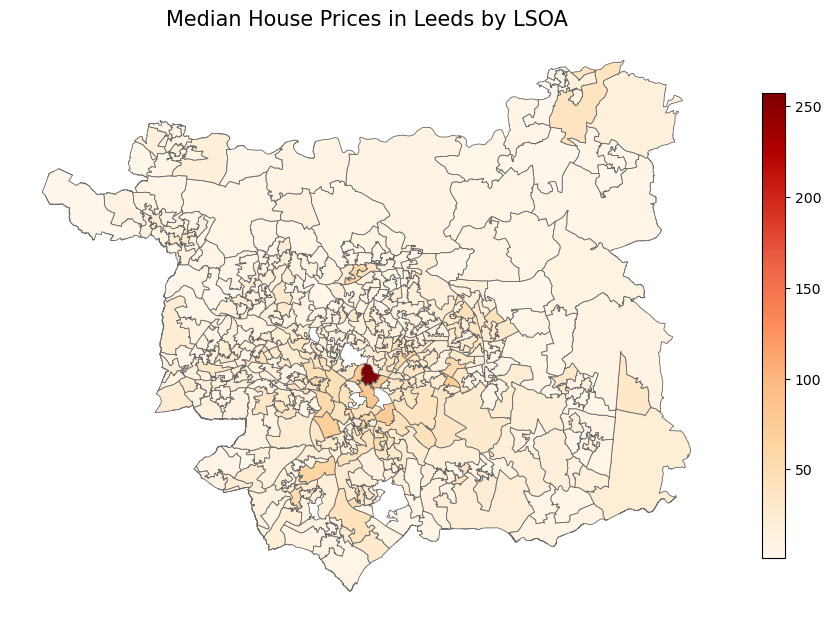

In [119]:
Merged = SHP.merge(CrimeData,on = "LSOA code")
fig,ax = plt.subplots(1,1,figsize = (10,10))
Merged.plot(column = "Total Crime",cmap = "OrRd",linewidth = 0.6,ax = ax,edgecolor = "0.4")
ax.set_title("Median House Prices in Leeds by LSOA",fontdict = {"fontsize":"15","fontweight":"3"})
ax.axis("off")
sm = plt.cm.ScalarMappable(cmap = "OrRd",norm = plt.Normalize(vmin = Merged["Total Crime"].min(),vmax = Merged["Total Crime"].max()))
sm._A = []
cbar = fig.colorbar(sm,ax = ax,fraction = 0.03)
plt.show() #......basicly the same as the previous one.

Notice the image? There is a significantly higher concentration of crimes in the city center of Leeds compared to other areas (worth thinking). Clearly, in comparison to this region, the crime data in other areas is almost indistinguishable. We need to examine what is happening with the crime data and how to address this issue.

In [121]:
CrimeData["Total Crime"].describe()

count    1395.000000
mean       18.805018
std        17.963956
min         1.000000
25%         8.000000
50%        15.000000
75%        24.000000
max       257.000000
Name: Total Crime, dtype: float64

The median value for the "Total Crime" column is 15, with the value at the 75% being 24. However, the maximum value is 257. We need to create a temporary crime map excluding this outlier to analyze the true trends within this data.

Text(0.5, 1.0, 'Total Crime Boxplot')

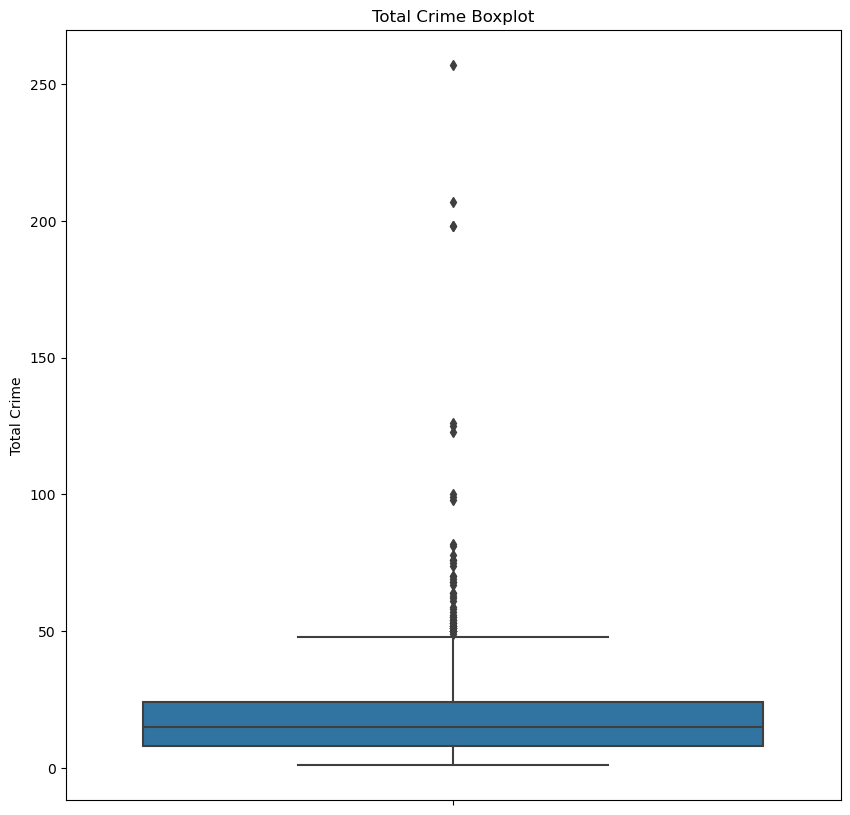

In [129]:
# Create a boxplot to see the general image of Total Crime column.
fig,axs = plt.subplots(1,1,figsize = (10,10))
sns.boxplot(y = CrimeData["Total Crime"],ax = axs)
axs.set_title("Total Crime Boxplot")

In this image, we found that the majority of the "Total Crime" data falls within the narrow range of 0-50, with only a few sparse points falling outside this range. Now, we can reassign these outlier points a value of 100. This adjustment will retain their uniqueness while enhancing the map's representation of the "Total Crime" data.

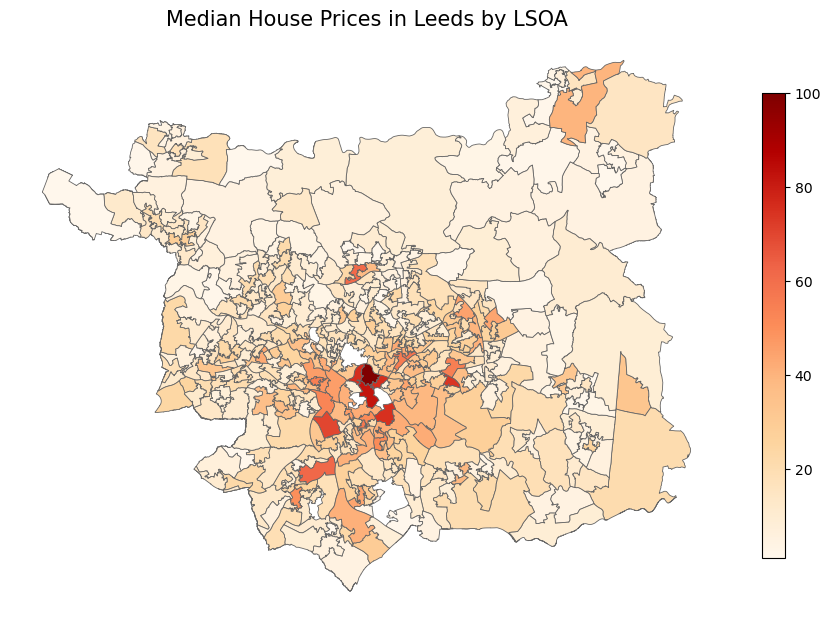

In [133]:
CrDa = CrimeData # A copy which will not affect the original dataframe.
CrDa.loc[CrDa["Total Crime"] > 100,"Total Crime"] = 100
Merged2 = SHP.merge(CrDa,on = "LSOA code")
fig,ax = plt.subplots(1,1,figsize = (10,10))
Merged2.plot(column = "Total Crime",cmap = "OrRd",linewidth = 0.6,ax = ax,edgecolor = "0.4")
ax.set_title("Median House Prices in Leeds by LSOA",fontdict = {"fontsize":"15","fontweight":"3"})
ax.axis("off")
sm = plt.cm.ScalarMappable(cmap = "OrRd",norm = plt.Normalize(vmin = Merged2["Total Crime"].min(),vmax = Merged2["Total Crime"].max()))
sm._A = []
cbar = fig.colorbar(sm,ax = ax,fraction = 0.03)
plt.show()

Now we can see that within the Leeds area, the closer to the city center, the higher the crime rate, and the southern part of Leeds tends to have higher crime rates than the northern part. This partly explains why there is an outlier with more than 250 crimes, as it is located at the center of the overall trend. Combined with our previous median house price map, we find that there seems to be a vague trend: in areas where the median house price is high, the crime rate is low; in areas where the median house price is low, the crime rate is relatively high.

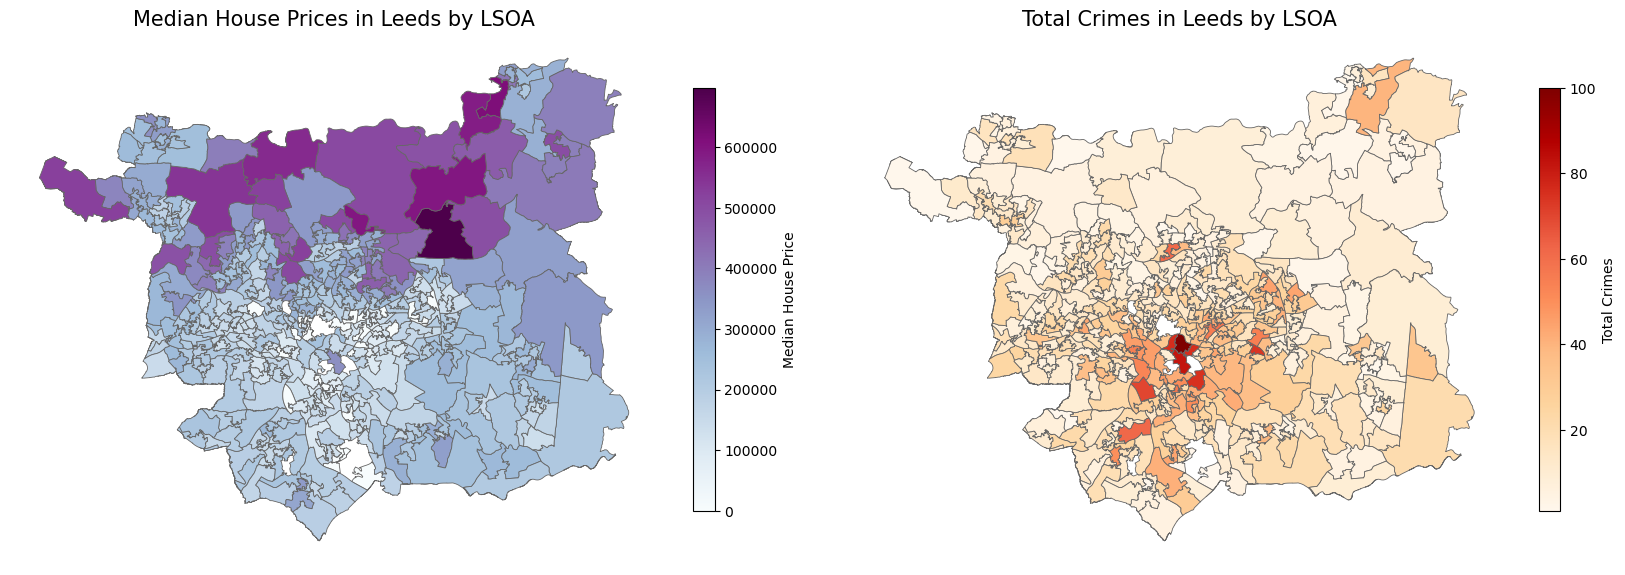

In [134]:
# Create a final image shows both house price and crime data.
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
Merged.plot(column="hpmd202103", cmap="BuPu", linewidth=0.6, ax=axes[0], edgecolor="0.4")
axes[0].set_title("Median House Prices in Leeds by LSOA", fontdict={"fontsize": "15", "fontweight": "3"})
axes[0].axis("off")
sm = plt.cm.ScalarMappable(cmap="BuPu", norm=plt.Normalize(vmin=Merged["hpmd202103"].min(), vmax=Merged["hpmd202103"].max()))
sm._A = []
cbar = fig.colorbar(sm, ax=axes[0], fraction=0.03)
cbar.set_label('Median House Price')
CrDa = CrimeData.copy()
CrDa.loc[CrDa["Total Crime"] > 100, "Total Crime"] = 100
Merged2 = SHP.merge(CrDa, on="LSOA code")
Merged2.plot(column="Total Crime", cmap="OrRd", linewidth=0.6, ax=axes[1], edgecolor="0.4")
axes[1].set_title("Total Crimes in Leeds by LSOA", fontdict={"fontsize": "15", "fontweight": "3"})
axes[1].axis("off")
sm = plt.cm.ScalarMappable(cmap="OrRd", norm=plt.Normalize(vmin=Merged2["Total Crime"].min(), vmax=Merged2["Total Crime"].max()))
sm._A = []
cbar = fig.colorbar(sm, ax=axes[1], fraction=0.03)
cbar.set_label('Total Crimes')
plt.show()

d:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
d:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


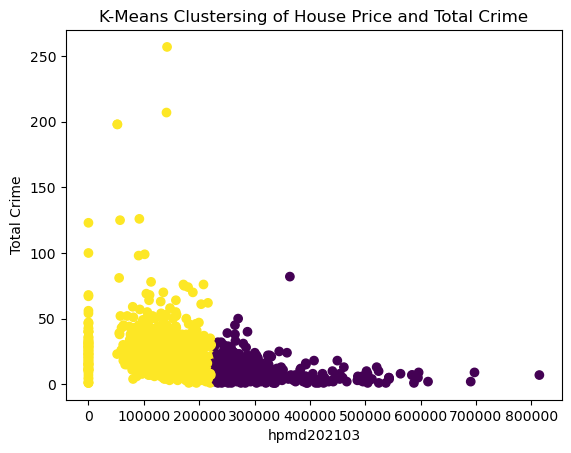

In [116]:
# To support our analysis, we will calculate the correlation between house price and total crime.
X = CrimeData[["hpmd202103","Total Crime"]]
kmeans = KMeans(n_clusters = 2,random_state = 0).fit(X) # KMeans clustering with 2 clusters
CrimeData["Cluster"] = kmeans.labels_ # Add the cluster labels to the dataframe
plt.scatter(CrimeData["hpmd202103"],CrimeData["Total Crime"],c = CrimeData["Cluster"],cmap = "viridis") # Scatter plot of house price and total crime
plt.xlabel("hpmd202103")
plt.ylabel("Total Crime")
plt.title("K-Means Clustersing of House Price and Total Crime")
plt.show()
# This is another final image.

The K-Means clustering analysis also supports our conclusions. From the K-Means plot, we can see a clear trend: areas with higher crime rates tend to have lower median house prices. The K-Means plot indicates a potential threshold around £250,000. In regions where the house prices are below this point, the crime rates are more likely to exceed the norm, reaching or even surpassing 100.

We can now conclude that within the Leeds area, there is a trend: the lower the median house price in a given region, the higher the local crime rate. This trend holds well for the northern, central, and southern parts of Leeds, but it does not have statistical significance in the northeast, southeast, and northwest directions.

Reference

CRDC.2024.Dwelling Ages and Prices.[online].[Accessed 2024/5/20].Available from:https://data.cdrc.ac.uk/dataset/dwelling-ages-and-prices

Office for National Statistics.2024.Counties and Unitary Authorities (December 2023) Boundaries UK BFC.[online].[Accessed 2024/5/20].Available from:https://geoportal.statistics.gov.uk/search?q=BDY_CTYUA;DEC_2023&sort=Title%7Ctitle%7Casc

West Yorkshire Police.2021.Crime Data.[online].[Accessed 2024/5/20].Available from:https://data.police.uk/data/